##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<table align="left">
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="../images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [11]:
!pip install -U -q "google-genai"

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [12]:
# Used to securely store your API key
from google.colab import userdata
from google import genai

API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=API_KEY)

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) from the open-source [SciKit project](https://scikit-learn.org/) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [13]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [14]:
idx = newsgroups_train.data[0].index("Lines")
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [15]:
import re

# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [
    re.sub(r"[\w\.-]+@[\w\.-]+", "", d) for d in newsgroups_train.data
]  # Remove email
newsgroups_train.data = [
    re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data
]  # Remove names
newsgroups_train.data = [
    d.replace("From: ", "") for d in newsgroups_train.data
]  # Remove "From: "
newsgroups_train.data = [
    d.replace("\nSubject: ", "") for d in newsgroups_train.data
]  # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [
    d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data
]

In [16]:
import pandas as pd

# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=["Text"])
df_train["Label"] = newsgroups_train.target
# Match label to target name index
df_train["Class Name"] = df_train["Label"].map(
    newsgroups_train.target_names.__getitem__
)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [17]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (
    df_train.groupby("Label", as_index=False)
    .apply(lambda x: x.sample(SAMPLE_SIZE))
    .reset_index(drop=True)
)

# Choose categories about science
df_train = df_train[df_train["Class Name"].str.contains("sci")]

# Reset the index
df_train = df_train.reset_index()
df_train

<ipython-input-17-dc22d2141534>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,(Stephan Neuhaus )Re: Do we need the clipper ...,11,sci.crypt
1,1651,Clipper considered harmful\nOrganization: Opt...,11,sci.crypt
2,1652,Re: Do we need the clipper for cheap security...,11,sci.crypt
3,1653,Re: What the clipper nay-sayers sound like to...,11,sci.crypt
4,1654,Re: Tempest\nNntp-Posting-Host: lonestar.utsa...,11,sci.crypt
...,...,...,...,...
595,2245,Re: Biosphere II\nOrganization: Express Acces...,14,sci.space
596,2246,Re: Proton/Centaur?\nOrganization: Express Ac...,14,sci.space
597,2247,Re: Proton/Centaur?\nOrganization: stanford\n...,14,sci.space
598,2248,Eco-Freaks forcing Space Mining.\nArticle-I.D....,14,sci.space


In [18]:
df_train["Class Name"].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the embeddings model, embedding-001, there is a task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [19]:
from tqdm.auto import tqdm
from google.genai import types

tqdm.pandas()

from google.api_core import retry
import numpy as np
import math


def make_embed_text_fn(model):

    @retry.Retry(timeout=300.0)
    def embed_fn(texts: list[str]) -> list[list[float]]:
        # Set the task_type to CLUSTERING and embed the batch of texts
        embeddings = client.models.embed_content(
            model=model,
            contents=texts,
            config=types.EmbedContentConfig(task_type="CLUSTERING"),
        ).embeddings
        return np.array([embedding.values for embedding in embeddings])

    return embed_fn


def create_embeddings(df):
    MODEL_ID = "embedding-001" # @param ["embedding-001"] {allow-input: true}
    model = f"models/{MODEL_ID}"
    embed_fn = make_embed_text_fn(model)

    batch_size = 100  # at most 100 requests can be in one batch
    all_embeddings = []

    # Loop over the texts in chunks of batch_size
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df["Text"].iloc[i : i + batch_size].tolist()
        embeddings = embed_fn(batch)
        all_embeddings.extend(embeddings)

    df["Embeddings"] = all_embeddings
    return df


df_train = create_embeddings(df_train)
df_train.drop("index", axis=1, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [20]:
len(df_train["Embeddings"][0])

768

In [21]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train["Embeddings"].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [23]:
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["Class Name"] = df_train[
    "Class Name"
]  # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-53.639164,-3.299784,sci.crypt
1,-49.193142,-0.482731,sci.crypt
2,-46.827904,1.088514,sci.crypt
3,-45.894054,4.784055,sci.crypt
4,-28.118715,-5.971164,sci.crypt
...,...,...,...
595,21.329044,5.078506,sci.space
596,6.284564,15.643859,sci.space
597,5.647338,15.452088,sci.space
598,18.448582,10.557105,sci.space


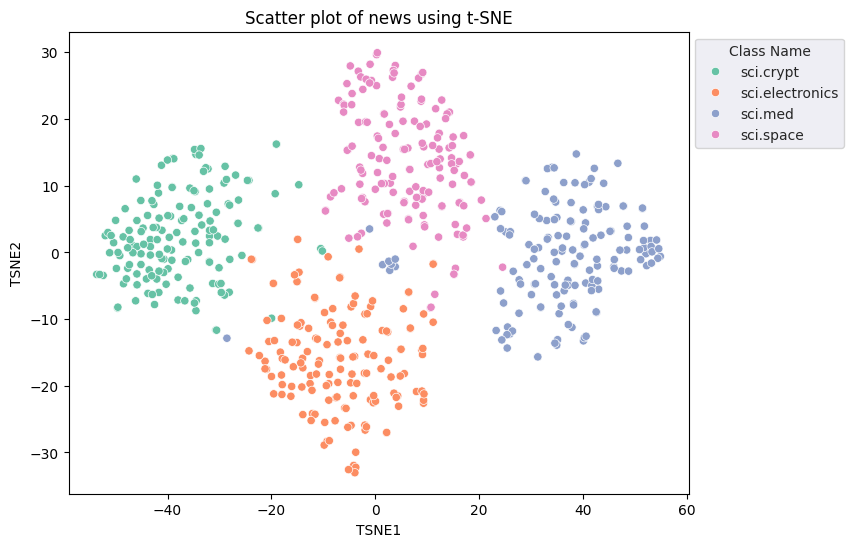

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [25]:
def get_centroids(df_tsne):
    # Get the centroid of each cluster
    centroids = df_tsne.groupby("Class Name").mean()
    return centroids


centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-37.683636,2.272167
sci.electronics,-6.688658,-15.887882
sci.med,36.054150,-0.565568
sci.space,6.109181,13.656686


In [26]:
def get_embedding_centroids(df):
    emb_centroids = dict()
    grouped = df.groupby("Class Name")
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        # Get the centroid value of dimension 768
        emb_centroids[c] = np.mean(sub_df["Embeddings"], axis=0)

    return emb_centroids

In [27]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

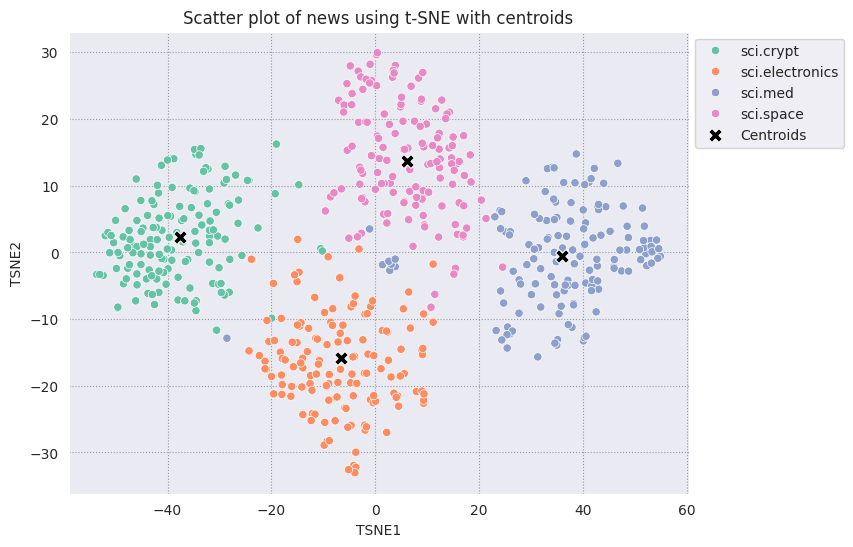

In [28]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news using t-SNE with centroids")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [29]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))


def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row["Class Name"]  # Get class name of row
        # Compare centroid distances
        dist = calculate_euclidean_distance(
            row["Embeddings"], emb_centroids[class_name]
        )
        df.at[idx, "Outlier"] = dist > radius

    return len(df[df["Outlier"] == True])

In [30]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
    num_outliers.append(detect_outlier(df_train, emb_c, i))

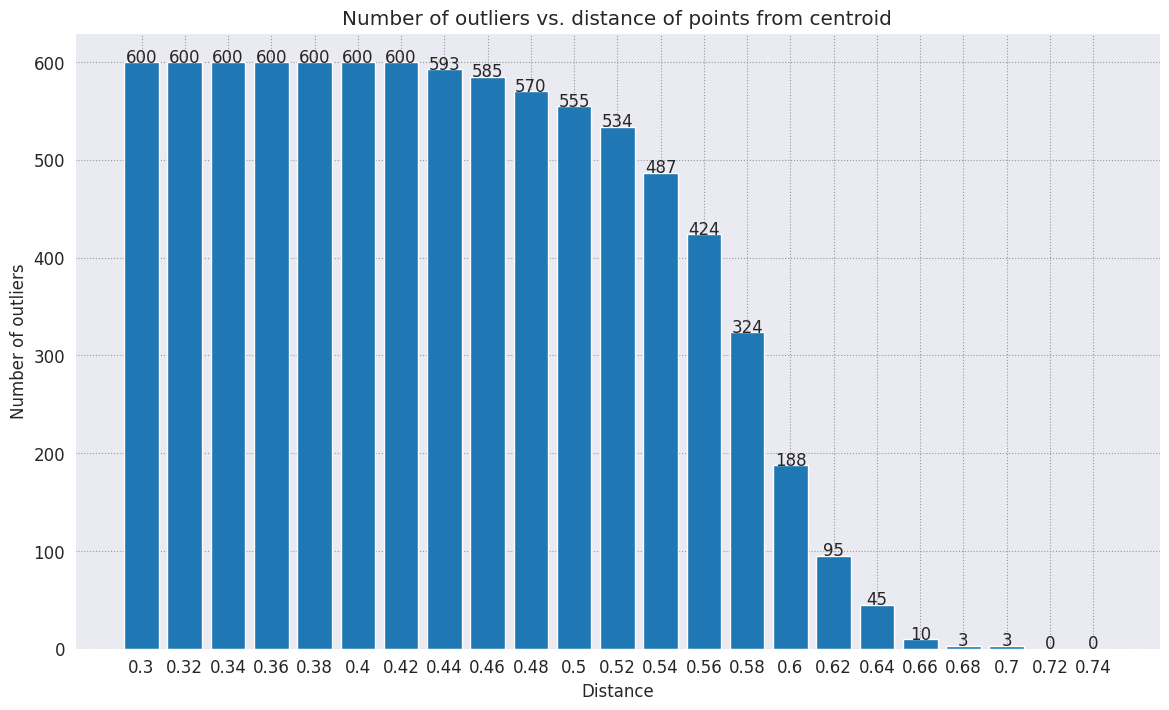

In [31]:
# Plot range_ and num_outliers
fig = plt.figure(figsize=(14, 8))
plt.rcParams.update({"font.size": 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha="center")

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [32]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train["Outlier"] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
16,Re: What is going on?...\nOrganization: Simon...,11,sci.crypt,"[-0.00076625106, -0.02913825, -0.054830864, -0...",True
17,Re: What is going on?...\nLines: 17\nOrganiza...,11,sci.crypt,"[-0.0046481607, -0.034073144, -0.045407247, -0...",True
26,Re: **Sorry folks** \nOriginator: \nNntp-Post...,11,sci.crypt,"[0.032511484, -0.038946625, -0.05624918, -0.06...",True
27,ISSA '93 Conference\nOrganization: Chinet - P...,11,sci.crypt,"[0.045426954, -0.0045831413, -0.026651457, -0....",True
31,Cryptography FAQ 04/10 - Mathematical Cryptolo...,11,sci.crypt,"[0.0022418664, -0.061940953, -0.04711892, -0.0...",True


In [33]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers["Outlier"].index]

Plot the outliers and denote them using a transparent red color.

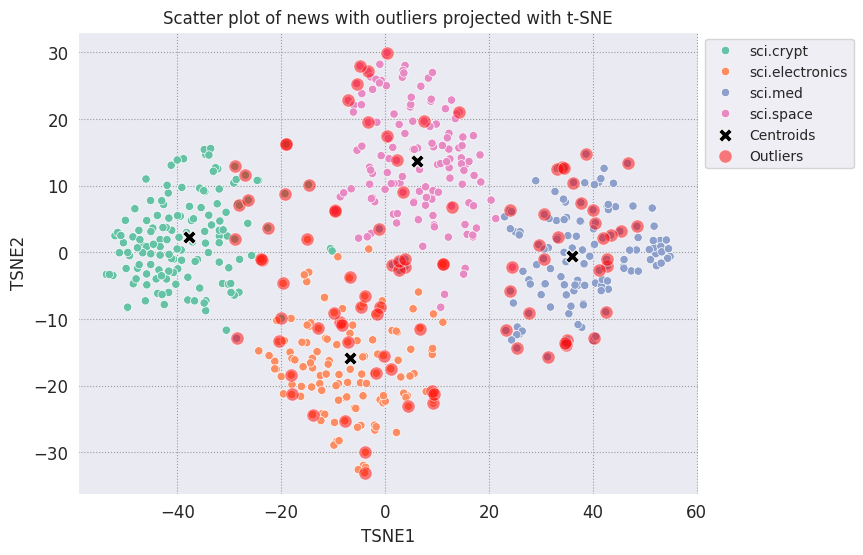

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize
plt.rcParams.update({"font.size": 10})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Class Name", palette="Set2")
sns.scatterplot(
    data=centroids,
    x="TSNE1",
    y="TSNE2",
    color="black",
    marker="X",
    s=100,
    label="Centroids",
)
# Draw a red circle around the outliers
sns.scatterplot(
    data=outliers_projected,
    x="TSNE1",
    y="TSNE2",
    color="red",
    marker="o",
    alpha=0.5,
    s=90,
    label="Outliers",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of news with outliers projected with t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2");

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [35]:
sci_crypt_outliers = df_outliers[df_outliers["Class Name"] == "sci.crypt"]
print(sci_crypt_outliers["Text"].iloc[0])

 Re: What is going on?...
Organization: Simon Fraser University, Burnaby, B.C., Canada
Distribution: inet
Lines: 13

  writes:

>In article <>,   writes:
>...
>> If you can't be bothered reading, get the video "Manufacturing Consent".
>> 

>In reply to mail queries; I don't know if a video is available yet. I asked
>about a month ao and was told RSN.

Yes it is. From the National Film Board of Canada.
Guy




In [36]:
sci_elec_outliers = df_outliers[df_outliers["Class Name"] == "sci.electronics"]
print(sci_elec_outliers["Text"].iloc[0])

 Re: Info on NEC 3D Multisync monitor
Organization: The Inquiring Mind BBS  1 204 488-1607
Lines: 43

  writes:

> > I am looking for any info I can get on the NEC 3D monitor.
> > I know that it is a multisync but that is about all.
> > I plan on buying one second-hand in a while depending on its specs.
> > 
> > Does anyone know the min/max frequencies, whether it is interlaced, 
> > non-interlaced, or both, video compatability, etc?
> > I have seen a reference to it being .28 pitch with 1024 X 720 resolution 
> > and that it supports SVGA from one source and that it doesn't support 
> > SVGA from another source.  
> 
> I'm at home right now, and so am away from my monitor files; the following
> is off the top of my head, subject to revision, worth-what-ya-pay-for-it
> sort of info.  If you don't hear from anyone who has spec sheet in hand,
> e-mail me and I'll look it up.
> 
> If I'm remembering correctly, the 3D is a 14" 0.28 mm pitch multisync that
> covers at least VGA  to 1024 x 7

In [37]:
sci_med_outliers = df_outliers[df_outliers["Class Name"] == "sci.med"]
print(sci_med_outliers["Text"].iloc[0])

 Re: Science and methodology 
Originator: 
Distribution: inet
Nntp-Posting-Host: theseus.unx.sas.com
Organization: SAS Institute Inc.
Lines: 43


In article <>,   writes:
|> -*-----
|> In article <>   writes:
|> > What about Kekule's infamous derivation of the idea of benzene rings
|> > from a daydream of snakes in the fire biting their tails?  Is this
|> > specific enough to count?  Certainly it turns up repeatedly in basic
|> > phil. of sci. texts as an example of the inventive component of
|> > hypothesizing. 
|> 
|> I think the question is: What is extra-scientific about this?  
|> 
|> It has been a long time since anyone has proposed restrictions on
|> where one comes up with ideas in order for them to be considered
|> legitimate hypotheses.  The point, in short, is this: hypotheses and
|> speculation in science may come from wild flights of fancy, 
|> daydreams, ancient traditions, modern quackery, or anywhere else.
|> 
|> Russell
|> 

Yes, but typically they *don't*.  Not every 

In [38]:
sci_space_outliers = df_outliers[df_outliers["Class Name"] == "sci.space"]
print(sci_space_outliers["Text"].iloc[0])

 Stephen Hawking Tours JPL
Organization: Jet Propulsion Laboratory
Lines: 68
Distribution: world
NNTP-Posting-Host: kelvin.jpl.nasa.gov
Keywords: JPL
News-Software: VAX/VMS VNEWS 1.41    

From the "JPL Universe"
April 23, 1993

Cosmologist Stephen Hawking tours Lab

By Karre Marino
     Some 15 years after his first visit to JPL, Prof. Stephen
Hawking, Lucasian professor of mathematics at Cambridge
University and author of "A Brief History of Time," returned to
the Lab April 5.
     On a tour hosted by JPL Chief Scientist Dr. Moustafa Chahine
and Merle McKenzie, manager of the International Affairs Office,
Hawking visited a variety of facilities, met with Lab Director
Dr. Edward Stone and various project scientists and managers, and
felt "like royalty," he said. Hawking, whose theories attempt to
explain the origin of distant galaxies, black holes and alternate
dimensions, wanted to re-visit JPL, he explained, "because while
I'm most interested in those things in space that are farthe

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).